In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix, eye
import networkx as nx
import matplotlib.pyplot as plt
import grblas
from grblas import Matrix, Vector, Scalar
from grblas import descriptor
from grblas import unary, binary, monoid, semiring, op
from grblas import io as gio

## Create and visualize a Matrix

In [2]:
# 23   // The input matrix A must be symmetric.  Self-edges (diagonal entries) are
# 24   // OK, and are ignored.  The values and type of A are ignored; just its
# 25   // pattern is accessed.
row_col = np.array(
    [
        [0, 0, 0, 1, 2, 2, 3, 6, 6, 9, 9],
        [1, 2, 3, 2, 4, 5, 4, 7, 8, 10, 11],
    ]
)
rows, cols = row_col
data = np.full_like(rows, fill_value=1)

In [3]:
A = coo_matrix((data, (rows, cols)), shape=(12, 12)).tolil()
A[cols, rows] = A[rows, cols]  # symmetrize matrix
A = A.tocoo()

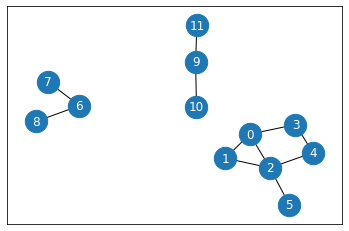

In [4]:
# Draw A using spring layout which may even reveal the connected components
G = nx.convert_matrix.from_scipy_sparse_matrix(A)
layout = nx.drawing.layout.spring_layout(G, k=0.6, scale=1, threshold=1e-10)
nx.draw_networkx(G, with_labels=True, node_size=500, font_color="w", pos=layout)

In [5]:
A = gio.from_scipy_sparse_matrix(A, name="A")
# Size of the sparse matrix is 12x12 with 22 non-zero elements of type INT64

In [6]:
A
# This is an adjacency matrix
# Reading along a row shows the out-nodes of a vertex
# Reading along a column shows the in-nodes of a vertex

"A"            nvals  nrows  ncols  dtype         format
grblas.Matrix     22     12     12  INT32  bitmapr (iso)
--------------------------------------------------------
   0  1  2  3  4  5  6  7  8  9  10 11
0      1  1  1                        
1   1     1                           
2   1  1        1  1                  
3   1           1                     
4         1  1                        
5         1                           
6                        1  1         
7                     1               
8                     1               
9                                 1  1
10                             1      
11                             1

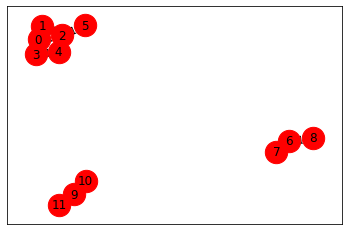

In [7]:
# grblas.io.draw could do with a few more tunable options to improve pretty display
gio.draw(A)

## Connected Components

https://github.com/GraphBLAS/LAGraph/blob/reorg/src/algorithm/LAGraph_ConnectedComponents.c

Sections of the C-code found at the above link are reproduced here in comments and translated into python

In [8]:
# 10    // Code is based on the algorithm described in the following paper
# 11    // Zhang, Azad, Hu. FastSV: FastSV: A Distributed-Memory Connected Component
# 12    // Algorithm with Fast Convergence (SIAM PP20)
# 13
# 14    // A subsequent update to the algorithm is here (which might not be reflected
# 15    // in this code):
# 16    //
# 17    // Yongzhe Zhang, Ariful Azad, Aydin Buluc: Parallel algorithms for finding
# 18    // connected components using linear algebra. J. Parallel Distributed Comput.
# 19    // 144: 14-27 (2020).

In [9]:
# 342      GrB_TRY (GrB_Matrix_nrows (&n, S)) ;
# 343      GrB_TRY (GrB_Matrix_nvals (&nnz, S)) ;
n = A.nrows
nnz = A.nvals

In [10]:
# 370      // vectors
# 371      GrB_TRY (GrB_Vector_new (&f,      GrB_UINT32, n)) ;
# 372      GrB_TRY (GrB_Vector_new (&gp_new, GrB_UINT32, n)) ;
# 373      GrB_TRY (GrB_Vector_new (&mod,    GrB_BOOL,   n)) ;
dtype = np.uint32
f = Vector.new(dtype=dtype, size=n, name="parents")  # parent of each vertex
gp_new = Vector.new(dtype=dtype, size=n, name="grandparents")  # grandparent of each vertex
mod = Vector.new(dtype=bool, size=n, name="modified?")  # boolean flag for each vertex
f

"parents"      nvals  size   dtype  format
grblas.Vector      0    12  UINT32  sparse
------------------------------------------
 0  1  2  3  4  5  6  7  8  9  10 11

In [11]:
mod

"modified?"    nvals  size  dtype  format
grblas.Vector      0    12   BOOL  sparse
-----------------------------------------
 0  1  2  3  4  5  6  7  8  9  10 11

In [12]:
# 387      GrB_TRY (GrB_Vector_build (f, I, V32, n, GrB_PLUS_UINT32)) ;
# 388      GrB_TRY (GrB_Vector_dup (&gp,   f)) ;
# 389      GrB_TRY (GrB_Vector_dup (&mngp, f)) ;
I = np.arange(n)
V32 = I.astype(dtype)
f.build(I, V32)  # The parent of each vertex is initialized to be the vertex itself
gp = f.dup()  # grandparent of each vertex initialized to parent
mngp = f.dup(name="Minimum grandparent")  # minimum grandparent of each vertex belonging to a star

In [13]:
f
# The parent of each vertex is initialized to the vertex itself

"parents"      nvals  size   dtype  format
grblas.Vector     12    12  UINT32    full
------------------------------------------
 0  1  2  3  4  5  6  7  8  9   10  11
  0  1  2  3  4  5  6  7  8  9  10  11

In [14]:
change = Scalar.new(dtype=bool, name="changed?")  # flag to terminate FastSV algorithm

This uses the ***min_second*** semiring with the *GrB_mxv()* function where *min* returns the minimum of its two inputs and *second* returns its second input.

In [15]:
# 703         // hooking & shortcutting
# 704         GrB_TRY (GrB_mxv (mngp, NULL, GrB_MIN_UINT32,
# 705                           GrB_MIN_SECOND_SEMIRING_UINT32, T, gp, NULL)) ;
mngp(binary.min) << op.min_second(A @ gp)
mngp

"Minimum grandparent"  nvals  size   dtype  format
grblas.Vector             12    12  UINT32    full
--------------------------------------------------
 0  1  2  3  4  5  6  7  8  9  10 11
  0  0  0  0  2  2  6  6  6  9  9  9

It is not yet clear to me if the function ***Reduce_assign32*** (described in the C-code) instead of ***GrB_assign*** is really required for the algorithm to work, as it is not referred to in any of the authors' papers.  Nevertheless, I'm choosing ***GrB_assign***, in accordance with authors' papers.  This seems to work anyway for the example graph used here.

In [16]:
# 706        GrB_TRY (Reduce_assign32 (&f, &mngp, V32, n, nthreads, ht_key,
# 707                                  ht_val, &seed, msg)) ;
#
#
# 139   //------------------------------------------------------------------------------
# 140   // Reduce_assign32:  w (index) += s, using MIN as the "+=" accum operator
# 141   //------------------------------------------------------------------------------
# 142
# 143   // mask = NULL, accumulator = GrB_MIN_UINT32, descriptor = NULL.
# 144   // Duplicates are summed with the accumulator, which differs from how
# 145   // GrB_assign works.  GrB_assign states that the presence of duplicates results
# 146   // in undefined behavior.  GrB_assign in SuiteSparse:GraphBLAS follows the
# 147   // MATLAB rule, which discards all but the first of the duplicates.
# 148
# 149   // todo: add this to GraphBLAS as a variant of GrB_assign, either as
# 150   // GxB_assign_accum (or another name), or as a GxB_* descriptor setting.
#       et cetera
#
#
f(binary.min)[V32] << mngp

In [17]:
# 708        GrB_TRY (GrB_eWiseAdd (f, NULL, GrB_MIN_UINT32, GrB_MIN_UINT32,
# 709                               mngp, gp, NULL)) ;
f(binary.min) << op.min(mngp | gp)

In [18]:
# 710        // calculate grandparent
# 711        // fixme: NULL parameter is SS:GrB extension
# 712        GrB_TRY (GrB_Vector_extractTuples (NULL, V32, &n, f)) ; // fixme
_, V32 = f.to_values()
V32

array([0, 0, 0, 0, 2, 2, 6, 6, 6, 9, 9, 9], dtype=uint32)

In [19]:
I = V32.astype(I.dtype)

In [20]:
# 719        GrB_TRY (GrB_extract (gp_new, NULL, NULL, f, I, n, NULL)) ;
gp_new << f[I]

In [21]:
# 721        // check termination
# 722        GrB_TRY (GrB_eWiseMult (mod, NULL, NULL, GrB_NE_UINT32, gp_new, gp,
# 723            NULL)) ;
# 724        GrB_TRY (GrB_reduce (&change, NULL, GrB_LOR_MONOID_BOOL, mod, NULL)) ;
mod << gp_new.ewise_mult(gp, binary.ne)
change << mod.reduce(binary.lor)

In [22]:
mod

"modified?"    nvals  size  dtype  format
grblas.Vector     12    12   BOOL    full
-----------------------------------------
     0     1     2     3     4     5      6     7     8      9     10    11
  False  True  True  True  True  True  False  True  True  False  True  True

In [23]:
change

"changed?"     value  dtype
grblas.Scalar   True   BOOL

In [24]:
change.value

True

In [25]:
# 726        // swap gp and gp_new
# 727        GrB_Vector t = gp ; gp = gp_new ; gp_new = t ;
gp, gp_new = gp_new, gp

The algorithm repeats until a new computation is the same as the previous result.

Here is the full python listing updated using changes from authors' paper: Yongzhe Zhang et al., J. Parallel Distributed Comput. 19 144: 14-27 (2020)):

In [26]:
def fastSV(A):
    n = A.nrows
    I = np.arange(n)
    # The parent of each vertex is initialized to be the vertex itself:
    f = Vector.from_values(I, I, name="parents")
    gp = f.dup()  # grandparent of each vertex initialized to parent
    gp_dup = gp.dup()  # duplicate grandparents
    mngp = f.dup()  # minimum grandparent of each star-vertex

    # boolean flag for each vertex
    mod = Vector.new(dtype=bool, size=n, name="modified?")
    # flag to terminate FastSV algorithm
    change = Scalar.from_value(True, dtype=bool, name="changed?")

    while change:
        # Step 1: Hooking phase
        mngp << op.min_second(A @ gp)
        f(binary.min)[I] << mngp
        f << op.min(f | mngp)
        # Step 2: Shortcutting
        f << op.min(f | gp)
        # Step 3: Calculate grandparents
        _, I = f.to_values()
        gp << f[I]
        # Check termination
        mod << op.ne(gp_dup & gp)
        change << mod.reduce(binary.lor)
        gp_dup << gp

    return f

In [27]:
connected_components = fastSV(A)
connected_components

"parents"      nvals  size  dtype  format
grblas.Vector     12    12  INT32    full
-----------------------------------------
 0  1  2  3  4  5  6  7  8  9  10 11
  0  0  0  0  0  0  6  6  6  9  9  9

*connected_components* gives the label of the component to which each vertex belongs.

Compare with the graph drawing to check result:

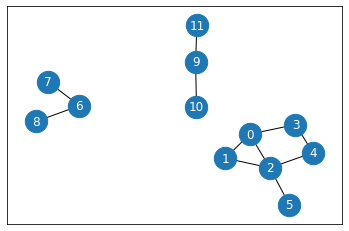

In [28]:
nx.draw_networkx(G, with_labels=True, node_size=500, font_color="w", pos=layout)

Each component has been identified and labeled with the least vertex ID in that component. 

### And that's FastSV in essentially 10 very readable lines of Python, thanks to GraphBLAS

Now let's test the algorithm a bit further by applying a random permutation to the vertex labels of the graph:

In [29]:
p = np.random.permutation(A.shape[0])

In [30]:
p

array([10,  3,  2, 11,  4,  6,  7,  5,  8,  0,  1,  9])

The permutation $\mathsf{p}$ can be viewed not only as a rearrangement of the vertex labels, but also as a bijection 
$$p: V \rightarrow V $$ 
from the set of vertices $V \subset \mathbb{Z}$ to itself.  So, for example, 
$$p(0) = \mathsf{p[0]}\mbox{,}\;\;p(1) = \mathsf{p[1]}\mbox{, ...} $$

I do not know if GraphBLAS provides primitives for permuting vertex labels.  It might be worthwhile to check.  Here I'll try using grblas: 

Let's build the above permutation's matrix $\mathbf{P}$ whose components are defined by:
$$P_{i\,j} \equiv \delta_{p(i)\, j},$$
where $\delta_{i\,j} = 1$ when $i=j$, otherwise $\delta_{i\,j} = 0$.  
Note that, 
$$ \sum_{j} j\,P_{i\,j} = \sum_{j} j\,\delta_{p(i)\, j} = p(i). $$
Also, it can be shown that
$$ \sum_{j} P^{\phantom{\mathrm{T}}}_{i\,j}P^{\mathrm{T}}_{j\,k} = \sum_{j} P_{i\,j}P_{k\,j} = \delta_{i\, k},$$
where $\mathrm{T}$ denotes the matrix transpose, and
$$P_{i\,j} = \delta_{p(i)\, j}  \iff P_{i\,p(j)} = \delta_{i\, j}.$$
We will now use the last equation above to build $\mathbf{P}$:

In [31]:
rows, cols = np.arange(p.size), p
data = np.full_like(rows, fill_value=1)
P = Matrix.from_values(rows, cols, data, name="P")

Check from the definition, $P_{i\,j} \equiv \delta_{p(i)\, j}$, that the nonzero matrix elements are indeed correctly placed:

In [32]:
P

"P"            nvals  nrows  ncols  dtype     format
grblas.Matrix     12     12     12  INT32  csr (iso)
----------------------------------------------------
   0  1  2  3  4  5  6  7  8  9  10 11
0                                 1   
1            1                        
2         1                           
3                                    1
4               1                     
5                     1               
6                        1            
7                  1                  
8                           1         
9   1                                 
10     1                              
11                             1

Now let us transform the adjacency matrix $\mathbf{A}$, using the permutation matrix $\mathbf{P}$, into 
$$\mathbf{A}' = \mathbf{P}^{\mathrm{T}} \cdot \mathbf{A} \cdot \mathbf{P},$$
which ensures that the graph edges are preserved after permutation, that is,
\begin{equation}
\boxed{A_{i\,j} = A'_{p(i)\,p(j)}}
\end{equation}
for all $i$, $j$.

In [33]:
AA = A.dup(name="AA")
AA << P.T @ A @ P

Let's redraw the graph with the new labels and compare with the permutation array and graph-drawing above.

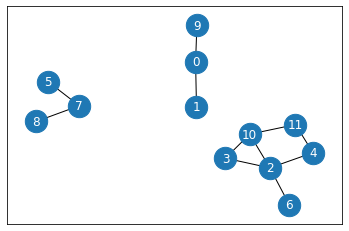

In [34]:
A_sci = gio.to_scipy_sparse_matrix(AA, format="csr")
G_perm = nx.convert_matrix.from_scipy_sparse_matrix(A_sci)
layout_perm = {p[k]: layout[k] for k in layout}
nx.draw_networkx(G_perm, with_labels=True, node_size=500, font_color="w", pos=layout_perm)

Now let's re-apply the algorithm:

In [35]:
connected_components_perm = fastSV(AA)
connected_components_perm

"parents"      nvals  size  dtype  format
grblas.Vector     12    12  INT32    full
-----------------------------------------
 0  1  2  3  4  5  6  7  8  9  10 11
  0  0  2  2  2  5  2  5  5  0  2  2

It looks like once again the algorithm worked as expected.  Let's confirm this programmatically by undoing the permutation on the result:

In [36]:
_, components_perm = connected_components_perm.to_values()

In [37]:
_, components = connected_components.to_values()

In [38]:
def assert_components_equal(components, components_perm, p):
    """
    This function undoes the vertex-label permutation p in
    components_perm and compares the result to the original
    components obtained before the permutation was applied.
    """
    # Undo the permutation in components_perm:
    components_unperm_not_min = components_perm[p]
    # Note that the resulting component-labels are not
    # necessarily the minimum vertex-labels for each
    # component.
    # Extract minimum vertex-label for each component:
    non_min_vertices, min_vertices = np.unique(components_unperm_not_min, return_index=True)
    # create a mapping from the non-minimum to minimum
    # component labels:
    q = p.copy()
    q[non_min_vertices] = min_vertices
    # apply the map:
    components_perm_undone = q[components_unperm_not_min]
    assert np.all(components == components_perm_undone)

In [39]:
assert_components_equal(components, components_perm, p)

To further test this assertion function, let us apply a second random permutation $p_2$ to the previous permutation:

In [40]:
p2 = np.random.permutation(A.shape[0])
p2

array([ 7,  1, 10,  4, 11,  0,  8,  5,  6,  3,  9,  2])

In [41]:
rows, cols = np.arange(p2.size), p2
data = np.full_like(rows, fill_value=1)
P = Matrix.from_values(rows, cols, data)

In [42]:
AAA = A.dup()
AAA << P.T @ AA @ P

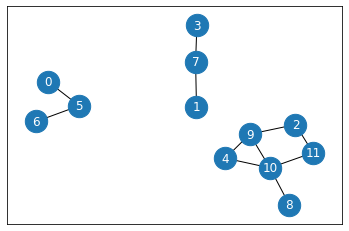

In [43]:
AAA_sci = gio.to_scipy_sparse_matrix(AAA, format="csr")
G_perm2 = nx.convert_matrix.from_scipy_sparse_matrix(AAA_sci)
layout_perm2 = {p2[k]: layout_perm[k] for k in layout_perm}
nx.draw_networkx(G_perm2, with_labels=True, node_size=500, font_color="w", pos=layout_perm2)

In [44]:
connected_components_perm2 = fastSV(AAA)
connected_components_perm2

"parents"      nvals  size  dtype  format
grblas.Vector     12    12  INT32    full
-----------------------------------------
 0  1  2  3  4  5  6  7  8  9  10 11
  0  1  2  1  2  0  0  1  2  2  2  2

In [45]:
_, components_perm2 = connected_components_perm2.to_values()

In [46]:
assert_components_equal(components_perm, components_perm2, p2)